Analysis of RTM using SVD method
===

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import CenteredNorm
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.lib.format import open_memmap
from raysect.optical import World

from cherab.phix.tools import laplacian_matrix, profile_1D_to_2D
from cherab.phix.tools.raytransfer import import_phix_rtc

RTM_DIR = Path().cwd().parent.parent.parent / "output" / "RTM" / "2022_12_13_00_49_29"

world = World()
rtc = import_phix_rtc(world)

Compare $L=\text{Laplacian}$ vs $L=I$
---
Let us see the difference of SVD components between $L=\text{laplacian}$ and $L=I$.

Load SVD matrices and values with $L=\text{Laplacian}$

In [2]:
u = open_memmap(RTM_DIR / "w_laplacian" / "u.npy")
s = open_memmap(RTM_DIR / "w_laplacian" / "s.npy")
vh = open_memmap(RTM_DIR / "w_laplacian" / "vh.npy")
L_inv_V = open_memmap(RTM_DIR / "w_laplacian" / "L_inv_V.npy")

Load SVD matrices and values without Laplacian i.e. $L=I$

In [3]:
u_w = open_memmap(RTM_DIR / "wo_laplacian" / "u.npy")
s_w = open_memmap(RTM_DIR / "wo_laplacian" / "s.npy")
vh_w = open_memmap(RTM_DIR / "wo_laplacian" / "vh.npy")

Singular values: $\sigma_i$
---

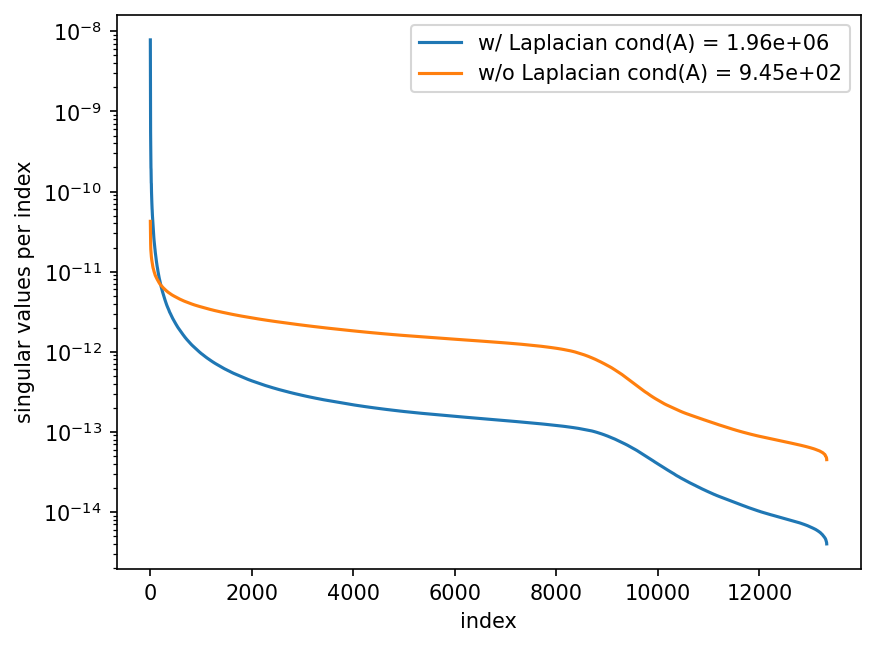

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.semilogy(s, label=f"w/ Laplacian cond(A) = {s.max() / s.min():.2e}")
ax.semilogy(s_w, label=f"w/o Laplacian cond(A) = {s_w.max() / s_w.min():.2e}")
ax.set_xlabel("index")
ax.set_ylabel("singular values per index")
ax.legend();

Basis vector: $L^{-1}v_i$
---
Theses vectors play a important role with tomographic reconstruction because the inverse solution
consists of the series of vector $L^{-1}v_i$, which is regarded as basis vectors of the solution.


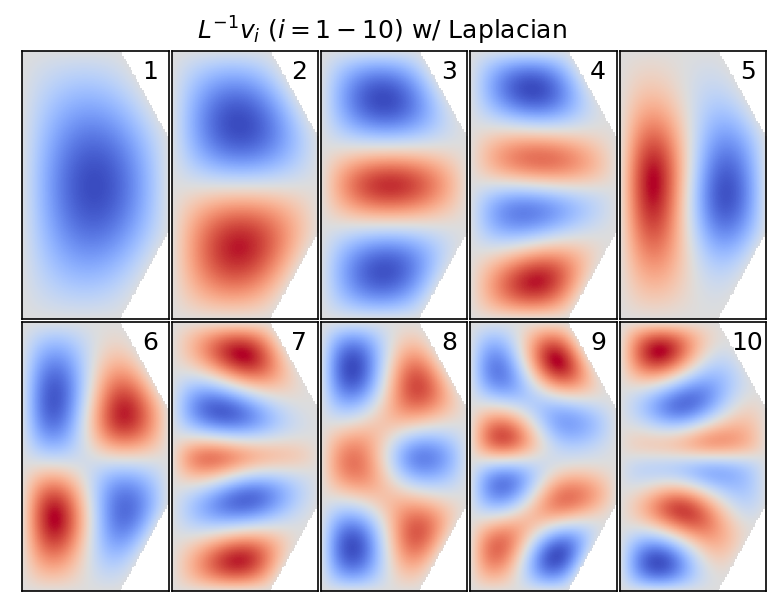

In [5]:
fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5))
for i in range(10):
    masked_profile2D = np.ma.masked_array(
        profile_1D_to_2D(L_inv_V[:, i], rtc), mask=np.logical_not(rtc.mask.squeeze())
    ).T
    grid[i].imshow(masked_profile2D, cmap="coolwarm", norm=CenteredNorm())
    grid[i].text(78, 5, f"{i+1}", fontsize=12, color="k", va="top", ha="center")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

fig.suptitle("$L^{-1}v_i\\ (i=1-10)$ w/ Laplacian", y=0.92);

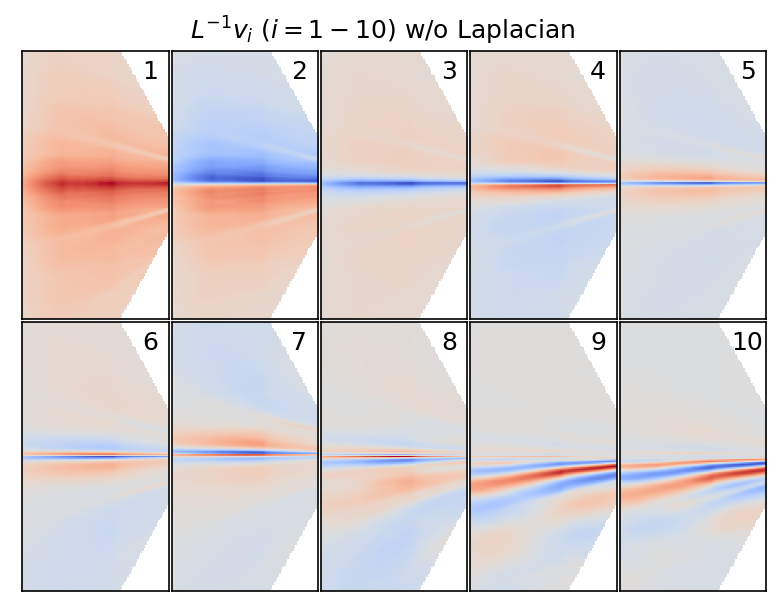

In [6]:
fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5))
for i in range(10):
    masked_profile2D = np.ma.masked_array(
        profile_1D_to_2D(vh_w[i, :], rtc), mask=np.logical_not(rtc.mask.squeeze())
    ).T
    grid[i].imshow(masked_profile2D, cmap="coolwarm", norm=CenteredNorm())
    grid[i].text(78, 5, f"{i+1}", fontsize=12, color="k", va="top", ha="center")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

fig.suptitle("$L^{-1}v_i\\ (i=1-10)$ w/o Laplacian", y=0.92);

Left-singular vectors: $u_i$
---
Theses vectors are related to the measured data, that is, camera images.
We can find the Laplacian effect in them as well.

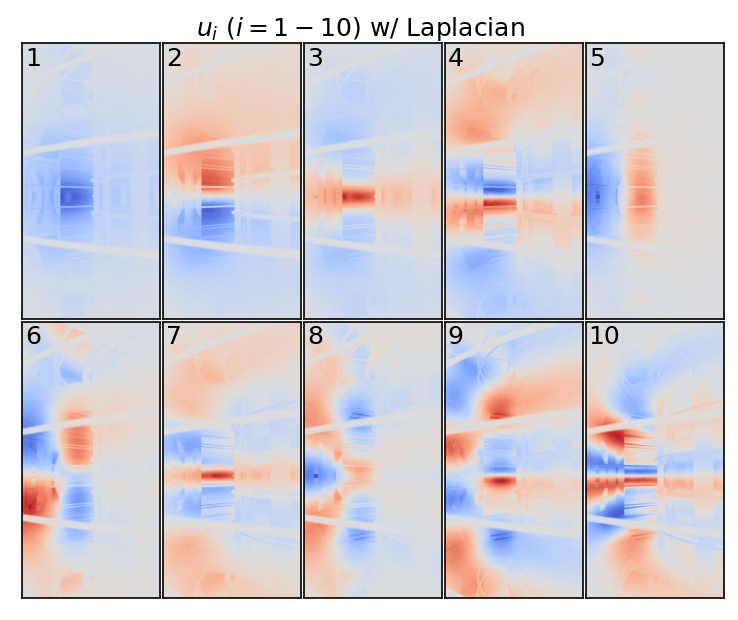

In [7]:
fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5))
for i in range(10):
    grid[i].imshow(u[:, i].reshape((256, 512)).T, cmap="coolwarm", norm=CenteredNorm())
    grid[i].text(5, 5, f"{i+1}", fontsize=12, color="k", va="top")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

fig.suptitle("$u_i\\ (i=1-10)$ w/ Laplacian", y=0.92);

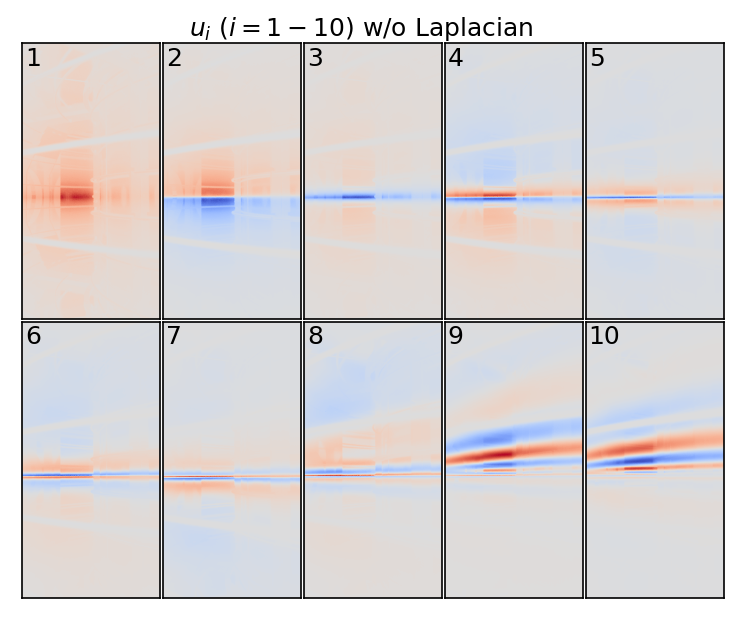

In [8]:
fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5))
for i in range(10):
    grid[i].imshow(u_w[:, i].reshape((256, 512)).T, cmap="coolwarm", norm=CenteredNorm())
    grid[i].text(5, 5, f"{i+1}", fontsize=12, color="k", va="top")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

fig.suptitle("$u_i\\ (i=1-10)$ w/o Laplacian", y=0.92);